# Pretraining a Born Classifier

We'd like to extract as much performance form Born as possible, without complicating the model (we've seen that ensembling is not particularly effective anyhow, see the `born_ensemble.ipynb` notebook).

Pretraining seems like a natural way to go about it!

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import json

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt 
import seaborn as sns

import joblib

from bornrule import BornClassifier

from utils import get_dataframe_for_pretraining, encode_categorical

## Data preparation

In [2]:
datadir = "data"
df_in = pd.read_parquet(os.path.join(datadir, "pretrain.parquet"))

df_out = get_dataframe_for_pretraining(df_in, num_processes=5)

[+] Loading data from prepared.parquet.


In [3]:
df_out.sample(15)

,sentence_id,token,pos,dep,ner_tag
29179658,7,",",PUNCT,punct,NONE
9592341,1,located,VERB,acl,NONE
16092638,2,to,ADP,prep,NONE
26379159,15,this,PRON,pobj,NONE
15072108,9,of,ADP,prep,NONE
15301383,4,offer,VERB,xcomp,NONE
8894143,10,to,PART,aux,NONE
33581051,1,from,ADP,prep,NONE
1960550,0,on,ADP,prep,NONE
12276619,8,in,ADP,prt,NONE


In [4]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35824413 entries, 0 to 35824412
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   sentence_id  int64 
 1   token        object
 2   pos          object
 3   dep          object
 4   ner_tag      object
dtypes: int64(1), object(4)
memory usage: 1.3+ GB


In [5]:
df_out['ner_tag'].value_counts()

ner_tag
NONE           26635602
ORG             2460284
PERSON          1723805
DATE            1662194
GPE             1188244
CARDINAL         425493
NORP             370960
LOC              271220
WORK_OF_ART      215003
FAC              195547
QUANTITY         193367
EVENT            176207
ORDINAL          122088
PRODUCT           51924
TIME              30588
LAW               29359
MONEY             27780
PERCENT           23396
LANGUAGE          21352
Name: count, dtype: int64

## Data processing

We'll encode the categorical values more or less as in the CoNLL case, i.e., to ordinal ones instead of one-hot encoded ones.

In [6]:
cols_to_encode = set(df_out.columns) - {'sentence_id', 'token'}
encoded_df, encoder_mappings = encode_categorical(df_out, cols_to_encode)

In [7]:
encoded_df.sample(15)

,sentence_id,token,ner_tag,dep,pos
15896773,4,This,9,29,10
22433404,0,was,9,0,3
17331653,1,the,9,20,5
11897379,0,Bavaria,14,14,11
19545853,1,Arica,4,35,11
21970804,8,playing,9,1,16
24207738,3,the,9,20,5
16397021,17,school,9,7,7
16100729,0,founded,9,1,16
8557356,1,words,9,35,7


Now we proceed as we did in the CoNLL notebook.

In [8]:
X_train_valid, X_test = train_test_split(encoded_df, test_size=0.15)
X_train, X_valid = train_test_split(X_train_valid, test_size=0.3)

In [9]:
y_train = X_train.ner_tag.to_list()
X_train = X_train.drop('ner_tag', axis=1)

y_valid = X_valid.ner_tag.to_list()
X_valid = X_valid.drop('ner_tag', axis=1)

y_test = X_test.ner_tag.to_list()
X_test = X_test.drop('ner_tag', axis=1)

In [10]:
dict_vec = DictVectorizer()

X_train = dict_vec.fit_transform(X_train.to_dict('records'))
X_val = dict_vec.transform(X_valid.to_dict('records'))
X_test = dict_vec.transform(X_test.to_dict('records'))

## Training

In [11]:
born = BornClassifier()
# ~8s to train on ~36M tokens is quite impressive!
born.fit(X_train, y_train)

BornClassifier()

We need to save the model, the fitted `DictVectorizer` and the fitted encoder mappings: these three pieces work together!

In [12]:
os.makedirs("runs", exist_ok=True)

In [22]:
timestamp = datetime.now().strftime("%d%m%Y-%H%M%S")

clf_path = os.path.join("runs", f"clf_born_{timestamp}.joblib")
joblib.dump(born, clf_path)
print(f"[+] Classifier saved to {clf_path}.")

vec_path = os.path.join("runs", f"vec_clf_born_{timestamp}.joblib")
joblib.dump(born, vec_path)
print(f"[+] Vectoriser saved to {vec_path}")

enc_maps_path = os.path.join("runs", f"encmap_clf_born_{timestamp}.json")
with open(enc_maps_path, "w") as file:
    json.dump(encoder_mappings, file)
print(f"[+] Encoder mappings saved to {enc_maps_path}")

[+] Classifier saved to runs/clf_born_28082024-165749.joblib.
[+] Vectoriser saved to runs/vec_clf_born_28082024-165749.joblib
[+] Encoder mappings saved to runs/encmap_clf_born_28082024-165749.json


In [14]:
y_pred = born.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred, labels=np.unique(y_train)))

              precision    recall  f1-score   support

           0       0.43      0.31      0.36     63725
           1       0.92      0.39      0.55    248802
           2       0.35      0.53      0.42     26584
           3       0.31      0.20      0.24     29418
           4       0.76      0.49      0.60    178431
           5       0.52      0.90      0.66      3214
           6       0.01      0.29      0.01      4467
           7       0.13      0.47      0.21     40492
           8       0.02      0.65      0.04      4063
           9       0.98      0.46      0.63   3995657
          10       0.76      0.70      0.73     55473
          11       0.07      0.97      0.13     18532
          12       0.86      0.15      0.26    369024
          13       0.06      0.56      0.11      3431
          14       0.13      0.93      0.22    258562
          15       0.10      0.31      0.15      7837
          16       0.61      0.49      0.54     29134
          17       0.08    

A curious result.

Perhaps visualising the confusion matrix will tell us more!

In [15]:
labels = encoder_mappings['ner_tag']
cm = confusion_matrix(y_test, y_pred, labels=range(len(labels)), normalize='true')

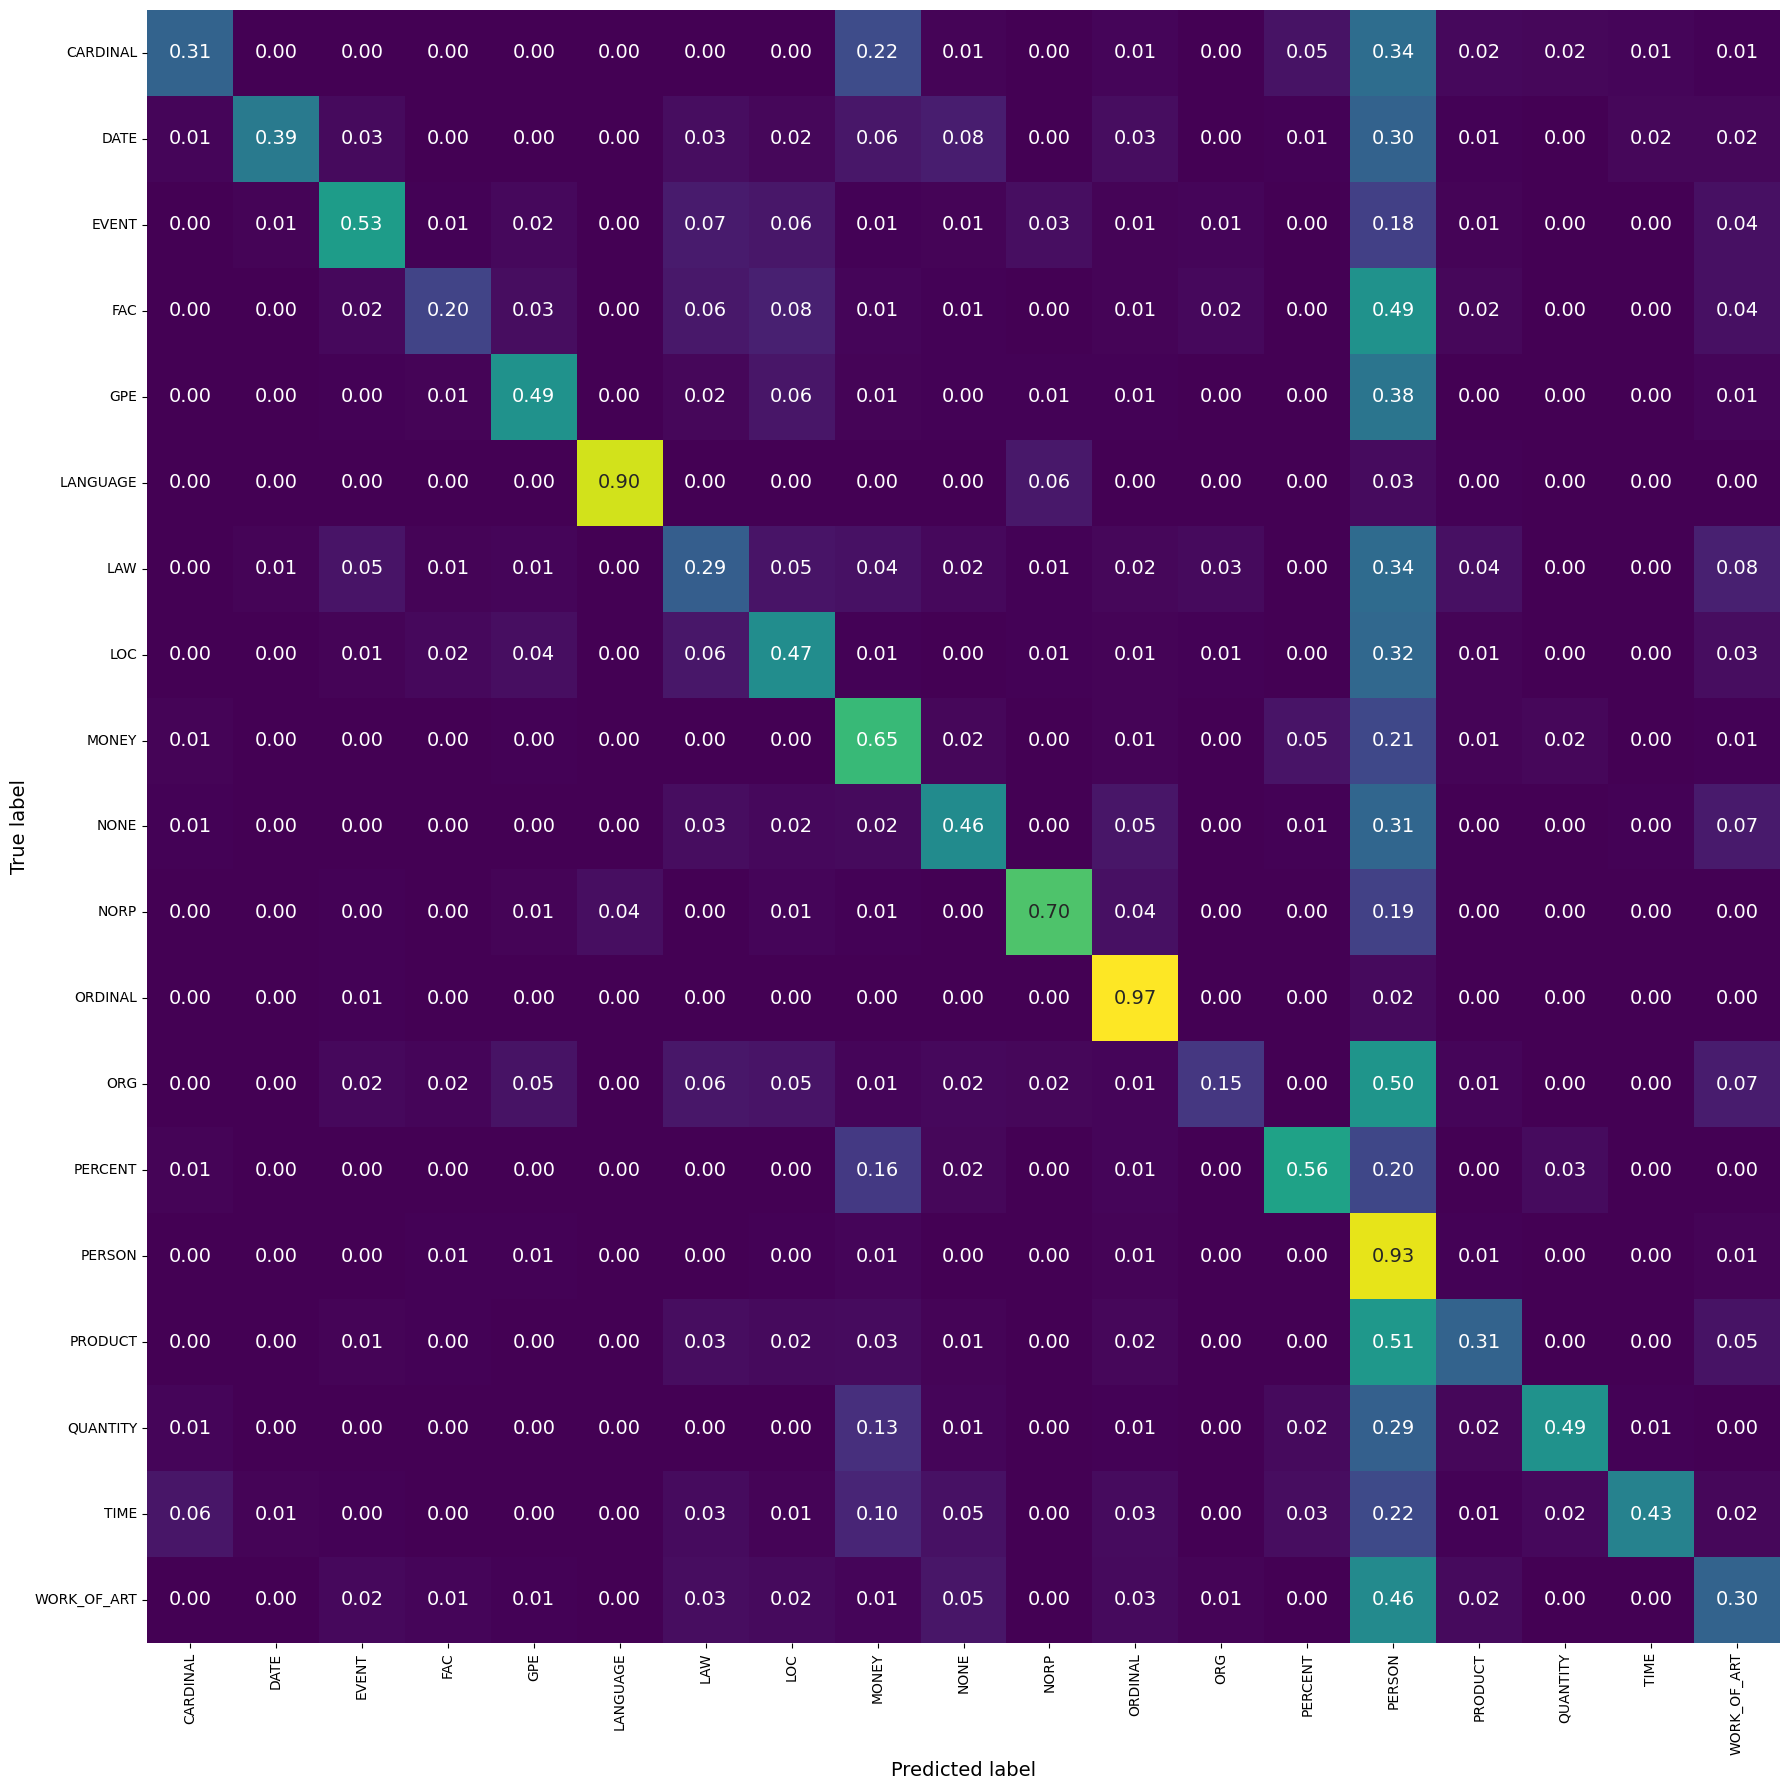

In [16]:
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(18, 18))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='viridis', 
            xticklabels=labels, yticklabels=labels, 
            annot_kws={'size': 14}, cbar=False)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

plt.tight_layout()
plt.show()

This confusion matrix is actually quite a bit more heartening than the classification report: it's quite clear that the classifier has, in fact, learned something!

It's interesting to note that it seems to be the most confused about the `PERSON` tag.
Intuitively, this is not exceedingly surprising, especially when one looks at what person entities are most often confused with:
- `ORG`s (unsurprisingly, seeing as many organisations are named after people),
- `PRODUCT`s (for more or less the same reason as with organisations),
- `FAC`s (unsurprisingly, seeing as infrastructure is often named after people, e.g., the JFK Airport).

## Explanation 

In [17]:
features = dict_vec.get_feature_names_out()
columns = encoder_mappings['ner_tag']
explain_df = pd.DataFrame(born.explain().toarray(), index=features, columns=columns)

Let's use the same example as in the `born_on_conll.ipynb` notebook.

In [18]:
explain_df.loc['token=EU'].sort_values(ascending=False)

ORG            0.001419
EVENT          0.000846
GPE            0.000470
WORK_OF_ART    0.000402
FAC            0.000347
PERSON         0.000272
NONE           0.000040
LOC            0.000000
MONEY          0.000000
DATE           0.000000
NORP           0.000000
ORDINAL        0.000000
LAW            0.000000
PERCENT        0.000000
LANGUAGE       0.000000
PRODUCT        0.000000
QUANTITY       0.000000
TIME           0.000000
CARDINAL       0.000000
Name: token=EU, dtype: float64

In [19]:
explain_df['LANGUAGE'].sort_values(ascending=False).head(15)

token=English       0.229449
token=Arabic        0.050895
token=Hebrew        0.050883
token=Spanish       0.034973
token=Filipino      0.034790
token=French        0.033499
token=Latin         0.024436
token=Chinese       0.015374
token=Russian       0.015044
token=Mandarin      0.013814
token=Portuguese    0.012140
token=German        0.011940
token=Cantonese     0.011565
token=Japanese      0.010646
token=Polish        0.009009
Name: LANGUAGE, dtype: float64